In [1]:
import cv2
from cv2 import aruco# Needs opencv-contrib-python==4.6.0.66
import os
import numpy as np
import matplotlib.pyplot as plt

### Old API

In [2]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
# board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
board = aruco.CharucoBoard_create(6, 4, 1, 0.5, aruco_dict)
imboard = board.draw((2000, 2000))

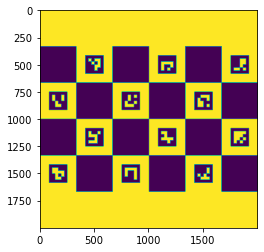

In [3]:
plt.imshow(imboard)
plt.show()

### Read images and resize them to have the same size

In [4]:
datadir_left = "./images/left/calibration/"
datadir_front = "./images/front/calibration/"
datadir_right = "./images/right/calibration/"

image_paths_left = np.array([datadir_left + f for f in os.listdir(datadir_left) if f.endswith(".JPG") ])
image_paths_front = np.array([datadir_front + f for f in os.listdir(datadir_front) if f.endswith(".JPG") ])
image_paths_right = np.array([datadir_right + f for f in os.listdir(datadir_right) if f.endswith(".JPG") ])

image_paths_left=sorted(image_paths_left)
image_paths_front=sorted(image_paths_front)
image_paths_right=sorted(image_paths_right)

In [5]:
len(image_paths_left), len(image_paths_front), len(image_paths_right)

(7, 7, 7)

In [6]:
img_left = cv2.imread(image_paths_left[0])
print("Left image shape: ", img_left.shape)

img_front = cv2.imread(image_paths_front[0])
print("Front image shape: ", img_front.shape)

img_right = cv2.imread(image_paths_right[0])
print("Right image shape: ", img_right.shape)

Left image shape:  (4872, 5568, 3)
Front image shape:  (4872, 5568, 3)
Right image shape:  (4176, 5568, 3)


In [7]:
images_left_uncut = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths_left]
images_front_uncut = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths_front]
images_right_uncut = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths_right]

Testing detections on different crops

In [ ]:
for i, (image_l, image_f, image_r) in enumerate(zip(images_left_uncut, images_front_uncut, images_right_uncut)):
    print("Image number: ", i)
    
    # two options: like this from 500 to 1500 for the second dimension start
    image_l = image_l[1000:4150, 1300:4450, :]
    image_f = image_f[1000:4150, 1300:4450, :]
    image_r = image_r[1000:4150, 1300:4450, :]

    gray = cv2.cvtColor(image_l, cv2.COLOR_RGB2GRAY)
    markers, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
    print("Left: ", len(markers))
    
    gray = cv2.cvtColor(image_f, cv2.COLOR_RGB2GRAY)
    markers, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
    print("Front: ", len(markers))
    
    gray = cv2.cvtColor(image_r, cv2.COLOR_RGB2GRAY)
    markers, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
    print("Right: ", len(markers))
    
    plt.imshow(image_l)
    plt.show()
    plt.imshow(image_f)
    plt.show()
    plt.imshow(image_r)
    plt.show()

In [183]:
# main crop value, 1300:4450 give best result
# images_left = [img[1000:4150, 1500:4500, :].copy() for img in images_left_uncut]
# images_front = [img[1000:4150, 1500:4500, :].copy() for img in images_front_uncut]
# images_right = [img[1000:4150, 1500:4500, :].copy() for img in images_right_uncut]

images_left = [img[1000:4150, 1300:4450, :].copy() for img in images_left_uncut]
images_front = [img[1000:4150, 1300:4450, :].copy() for img in images_front_uncut]
images_right = [img[1000:4150, 1300:4450, :].copy() for img in images_right_uncut]

# images_left = [cv2.resize(img[1000:4150, 1300:4450, :], (0,0), fx=0.85, fy=0.85) for img in images_left_uncut]
# images_front = [cv2.resize(img[1000:4150, 1300:4450, :], (0,0), fx=0.85, fy=0.85) for img in images_front_uncut]
# images_right = [cv2.resize(img[1000:4150, 1300:4450, :], (0,0), fx=0.85, fy=0.85) for img in images_right_uncut]


assert images_left[0].shape==images_front[0].shape==images_right[0].shape
imsize = images_right[0].shape[0:2]

In [184]:
imsize

(3150, 3150)

In [ ]:
# for image in images_right:
#     image[2250:, 1750:2250, :] = (0, 0, 0)
    
# plt.imshow(images_right[5])
# plt.show()

### Markers + corners

In [33]:
def read_chessboards(images, addEmpty=False):
    """
    Finding corners on a chessboard
    """
    chessCorners = []
    chessCornersIds = []
    
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for i, image in enumerate(images):
        print("=> Processing image {0}".format(i))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        markers, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        print("Number of markers detected: ", len(markers))

        if len(markers)>0:
            # SUB PIXEL DETECTION
            for marker in markers:
                # check whether this one is called correctly
                cv2.cornerSubPix(gray, marker,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
                
            res2 = cv2.aruco.interpolateCornersCharuco(markers, ids, gray, board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3:
                chessCorners.append(res2[1])
                chessCornersIds.append(res2[2])
            elif addEmpty:
                chessCorners.append(np.array([]))
                chessCornersIds.append(np.array([]))
        elif addEmpty:
            chessCorners.append(np.array([]))
            chessCornersIds.append(np.array([]))
#         print(len(chessCorners))

    return chessCorners, chessCornersIds

In [381]:
print("LEFT IMAGES")
allCorners_left, allIds_left = read_chessboards(images_left[1:2])
print("FRONT IMAGES")
allCorners_front, allIds_front = read_chessboards(images_front[1:2])
print("RIGHT IMAGES")
allCorners_right, allIds_right = read_chessboards(images_right[1:2])

LEFT IMAGES
=> Processing image 0
Number of markers detected:  10
FRONT IMAGES
=> Processing image 0
Number of markers detected:  12
RIGHT IMAGES
=> Processing image 0
Number of markers detected:  11


### Camera calibration

In [317]:
def calibrate_camera(allCorners, allIds):
    """
    Calibrates the camera using the dected corners.
    """
# 4872, 5568
    cameraMatrixInit = np.array([[ 3150.,    0., imsize[0]/2.],
                                 [    0., 3150., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
#     flags = (cv2.CALIB_RATIONAL_MODEL)
    
#     (ret, camera_matrix, distortion_coefficients0,
#      rotation_vectors, translation_vectors,
#      stdDeviationsIntrinsics, stdDeviationsExtrinsics,
#      perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
#                       charucoCorners=allCorners,
#                       charucoIds=allIds,
#                       board=board,
#                       imageSize=imsize,
#                       cameraMatrix=cameraMatrixInit,
#                       distCoeffs=distCoeffsInit,
#                       flags=flags,
#                       criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))
    
    ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors = aruco.calibrateCameraCharuco(
        charucoCorners=allCorners,
        charucoIds=allIds,
        board=board,
        imageSize=imsize,
        cameraMatrix=cameraMatrixInit,
        distCoeffs=None,
        flags=flags,
        criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9)
    )

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [382]:
calibration_parameters = {}

# results are ret, mtx, dist, rvecs, tvecs
res_left = calibrate_camera(allCorners_left, allIds_left)
print("Left camera calibration accuracy: ", res_left[0])
calibration_parameters['left'] = res_left

res_front = calibrate_camera(allCorners_front, allIds_front)
print("Front camera calibration accuracy: ", res_front[0])
calibration_parameters['front'] = res_front

res_right = calibrate_camera(allCorners_right, allIds_right)
print("Right camera calibration accuracy: ", res_right[0])
calibration_parameters['right'] = res_right

Left camera calibration accuracy:  0.13991297802096883
Front camera calibration accuracy:  0.153912513836919
Right camera calibration accuracy:  0.23172296131392542


In [ ]:
for img, corners, ids in zip(images_right, allCorners_right, allIds_right):
    for corner, c_id in zip(corners, ids):
        print(corner, c_id)
        c = img.copy()
        
        c = cv2.circle(c, (int(corner[0][0]), int(corner[0][1])), 10, (255, 0, 0), 5)
    
        plt.imshow(c)
        plt.show()

In [376]:
print("LEFT IMAGES")
allCorners_left, allIds_left = read_chessboards(images_left, addEmpty=True)
print("FRONT IMAGES")
allCorners_front, allIds_front = read_chessboards(images_front, addEmpty=True)
print("RIGHT IMAGES")
allCorners_right, allIds_right = read_chessboards(images_right, addEmpty=True)

LEFT IMAGES
=> Processing image 0
Number of markers detected:  12
=> Processing image 1
Number of markers detected:  10
=> Processing image 2
Number of markers detected:  10
=> Processing image 3
Number of markers detected:  9
=> Processing image 4
Number of markers detected:  9
=> Processing image 5
Number of markers detected:  0
=> Processing image 6
Number of markers detected:  12
FRONT IMAGES
=> Processing image 0
Number of markers detected:  12
=> Processing image 1
Number of markers detected:  12
=> Processing image 2
Number of markers detected:  13
=> Processing image 3
Number of markers detected:  12
=> Processing image 4
Number of markers detected:  12
=> Processing image 5
Number of markers detected:  12
=> Processing image 6
Number of markers detected:  2
RIGHT IMAGES
=> Processing image 0
Number of markers detected:  11
=> Processing image 1
Number of markers detected:  11
=> Processing image 2
Number of markers detected:  8
=> Processing image 3
Number of markers detected:

In [320]:
len(allCorners_left), len(allCorners_front), len(allCorners_right)

(7, 7, 7)

In [321]:
for l, f, r in zip(allCorners_left, allCorners_front, allCorners_right):
    
#     print(
#         l.shape if len(l) != 0 else (0, 0, 0), 
#         f.shape if len(f) != 0 else (0, 0, 0), 
#         r.shape if len(r) != 0 else (0, 0, 0),
#     )
    
    print(l.shape, f.shape, r.shape)

(15, 1, 2) (15, 1, 2) (13, 1, 2)
(10, 1, 2) (15, 1, 2) (13, 1, 2)
(11, 1, 2) (15, 1, 2) (6, 1, 2)
(8, 1, 2) (15, 1, 2) (15, 1, 2)
(10, 1, 2) (15, 1, 2) (15, 1, 2)
(0,) (15, 1, 2) (15, 1, 2)
(15, 1, 2) (0,) (0,)


In [40]:
def get_common_corners_and_objpoints(allCorners_first, allIds_first, allCorners_second, allIds_second):
    corners1 = []
    corners2 = []
    objpoints = []
    
    i = 0
    for corners_first, ids_first, corners_second, ids_second in zip(allCorners_first, allIds_first, allCorners_second, allIds_second):
        common_ids = set(ids_first.flatten()).intersection(ids_second.flatten())
        
        if len(common_ids) == 0:
            print(f"No corners retrieved in the {i} image")
            i += 1
            continue
        
        print(f"Corners retrieved in the {i} image", common_ids)
        i += 1
        
        objp = []
        for c_id in common_ids:
            # first row then columns or vice-versa
            x = c_id % 5
            y = c_id // 5
            
            objp.append([float(x), float(y), 0.0])
        objpoints.append(np.array(objp, dtype=np.float32))
            
        mask1 = list(map(lambda x: x[0] in common_ids, ids_first))
        mask2 = list(map(lambda x: x[0] in common_ids, ids_second))
        
        corners1.append(corners_first[mask1].squeeze(1))
        corners2.append(corners_second[mask2].squeeze(1))
        
        assert(len(corners_first[mask1])==len(corners_second[mask2])==len(objp))
        
    return corners1, corners2, objpoints
    

absolutely not sure about correctness of this code

In [209]:
#coordinates of squares in the checkerboard world space
rows = 3
columns = 5
world_scaling = 1. #change this to the real world square size. Or not.

# objp = np.zeros((rows*columns,3), np.float32)
# objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)

objp = np.zeros((rows*columns,3), np.float32)
objp[:,:2] = np.mgrid[0:columns,0:rows].T.reshape(-1,2)

objp = world_scaling* objp

In [205]:
objp

array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [0., 1., 0.],
       [1., 1., 0.],
       [2., 1., 0.],
       [0., 2., 0.],
       [1., 2., 0.],
       [2., 2., 0.],
       [0., 3., 0.],
       [1., 3., 0.],
       [2., 3., 0.],
       [0., 4., 0.],
       [1., 4., 0.],
       [2., 4., 0.]], dtype=float32)

### test only on subset of images, because all corners are detected (not sure what to do when some are missing)

first test (below):
result - 8046042.6635145815

if objp is transposed, value is 234.2782892562822

In [ ]:
corners_front_test = allCorners_front[3:6]
corners_right_test = allCorners_right[3:6]

corners_front_test = np.array(corners_front_test).squeeze(2)
corners_right_test = np.array(corners_right_test).squeeze(2)

corners1 = corners_front_test
corners2 = corners_right_test

mtx1 = calibration_parameters['front'][1]
dst1 = calibration_parameters['front'][2]

mtx2 = calibration_parameters['right'][1]
dst2 = calibration_parameters['right'][2]

#coordinates of the checkerboard in checkerboard world space.
objpoints = np.array([objp, objp, objp]) # 3d point in real world space

second test (below):
result - 235.98660161640714

In [216]:
corners_left_test = [allCorners_left[0], allCorners_left[-1]]
corners_front_test = [allCorners_front[0], allCorners_front[-1]]

corners_left_test = np.array(corners_left_test).squeeze(2)
corners_front_test = np.array(corners_front_test).squeeze(2)

corners1 = corners_front_test
corners2 = corners_left_test

mtx1 = calibration_parameters['front'][1]
dst1 = calibration_parameters['front'][2]

mtx2 = calibration_parameters['left'][1]
dst2 = calibration_parameters['left'][2]

#coordinates of the checkerboard in checkerboard world space.
objpoints = np.array([objp, objp]) # 3d point in real world space

In this test I collected all the images and selected the corners that are visible for both cameras

result for left and front: 2.211220747959163

result for right and front: 126.58889967955211

with crop from 1300:

2.248 and 20.57

In [405]:
corners1, corners2, objpoints = get_common_corners_and_objpoints(
    allCorners_front, 
    allIds_front,
    allCorners_left, 
    allIds_left, 
)

mtx1 = calibration_parameters['front'][1]
dst1 = calibration_parameters['front'][2]

mtx2 = calibration_parameters['left'][1]
dst2 = calibration_parameters['left'][2]

Corners retrieved in the 0 image {0, 1, 2, 3, 4, 5, 6, 9, 11, 14}


In [390]:
corners1, corners2, objpoints = get_common_corners_and_objpoints(
    allCorners_front, 
    allIds_front,
    allCorners_right, 
    allIds_right, 
)

mtx1 = calibration_parameters['front'][1]
dst1 = calibration_parameters['front'][2]

mtx2 = calibration_parameters['right'][1]
dst2 = calibration_parameters['right'][2]

Corners retrieved in the 0 image {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [406]:
ret, mat1, dist1, mat2, dist2, r,t, e, f = cv2.stereoCalibrate(
    objpoints, 
    corners1, 
    corners2, 
    mtx1,
    dst1,
    mtx2, 
    dst2,
    imsize
)

[ret, mat1, dist1, mat2, dist2, r,t, e, f]

[0.45837651879543817,
 array([[2.91167579e+03, 0.00000000e+00, 1.64979047e+03],
        [0.00000000e+00, 2.91167579e+03, 1.55604693e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-2.81555695e-01, -4.27912446e+00, -1.14097463e-01,
         -3.12666224e-02,  9.58595829e+01]]),
 array([[3.06502691e+03, 0.00000000e+00, 1.56726013e+03],
        [0.00000000e+00, 3.06502691e+03, 1.56798653e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-0.36173302, -1.56581615, -0.19303805,  0.03695501, -6.25797845]]),
 array([[ 0.84029728, -0.04114902, -0.54056197],
        [ 0.04444968,  0.99898746, -0.00694907],
        [ 0.54030058, -0.01818852,  0.8412755 ]]),
 array([[26.14884974],
        [-0.92225154],
        [10.09396186]]),
 array([[ -0.94696643, -10.06696689,  -0.70572393],
        [ -5.64630992,   0.06025226, -27.45479854],
        [  1.93727351,  26.08442312,  -0.6802444 ]]),
 array([[ 1.78115773e-08,  1.89350491e-07, -2.85373963e-04],
    

In [203]:
#projection matrix for front camera is identity
projection_front = mtx1 @ np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1) 
 
#projection matrix for left camera is the R and T obtained from stereo calibration
projection_left = mtx2 @ np.concatenate([r, t], axis = -1) 

In [204]:
projection_front

array([[1.69163127e+03, 0.00000000e+00, 1.43933018e+03, 0.00000000e+00],
       [0.00000000e+00, 1.69163127e+03, 1.59958275e+03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [205]:
projection_left

array([[ 1.78177131e+03,  3.06599385e+01,  6.31891001e+02,
         2.06983352e+04],
       [ 3.40424952e+02,  1.62835205e+03,  1.49894917e+03,
        -2.94856889e+03],
       [ 2.26062689e-01,  2.28924773e-02,  9.73843722e-01,
        -1.57182120e+00]])

### Testing fundamental matrix properties

In [425]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c, _ = img1.shape

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = (0, 255, 255)
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 10)
        img1 = cv2.circle(img1, (int(pt1[0]), int(pt1[1])), 25, color, -1)
        img2 = cv2.circle(img2, (int(pt2[0]), int(pt2[1])), 25, color, -1)
    return img1, img2

In [426]:
corner_index = 5

In [445]:
line_2 = cv2.computeCorrespondEpilines(np.array([[2000, 2500]]), 1, f)
# line_2 = cv2.computeCorrespondEpilines(allCorners_front[0][corner_index], 1, f)

In [449]:
line = f @ [2000, 2500, 1]

In [450]:
line

array([ 2.23625419e-04,  1.53971193e-03, -4.10914903e+00])

In [447]:
line_2 = line_2.squeeze(0).squeeze(0)
line_2

array([ 1.4373045e-01,  9.8961687e-01, -2.6410676e+03], dtype=float32)

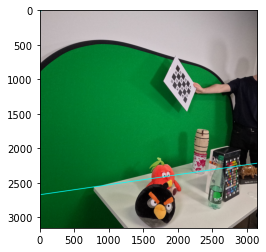

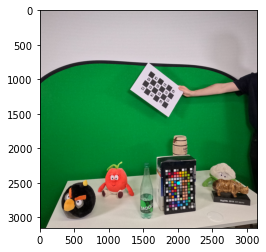

In [454]:
img1, img2 = drawlines(
                     images_left[1].copy(), 
                     images_front[1].copy(),
                     [line, line_2], 
#                      allCorners_left[0][corner_index], 
#                      allCorners_front[0][corner_index],
                    np.array([[0, 0]]),
                    np.array([[2000, 2500]])
    )
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

### Testing stereoCalibration using  only front- right on capture 6 and left-front on capture 7 (by Kevin, obsolete)

In [43]:
capture6Corners = [cam_calibrations[1]['allCorners'][0], cam_calibrations[2]['allCorners'][0]]#[Front, Right] capture6
capture7Corners = [cam_calibrations[0]['allCorners'][0], cam_calibrations[1]['allCorners'][1]]#[Left, Front] capture7
capture6Corners

[array([[[3851.5635, 2779.18  ]],
 
        [[3977.0615, 2778.7354]],
 
        [[4100.2603, 2778.6484]],
 
        [[4218.3076, 2777.967 ]],
 
        [[4341.2847, 2779.316 ]],
 
        [[3843.4675, 2921.3604]],
 
        [[3968.8757, 2919.3057]],
 
        [[4091.5208, 2917.5918]],
 
        [[4209.1265, 2915.009 ]],
 
        [[4332.0493, 2915.1948]],
 
        [[3835.0974, 3063.1145]],
 
        [[3960.4539, 3058.9773]],
 
        [[4082.6963, 3055.5178]],
 
        [[4200.1396, 3051.0261]],
 
        [[4323.263 , 3050.3745]]], dtype=float32),
 array([[[1934.5576, 1812.388 ]],
 
        [[2023.0532, 1821.8383]],
 
        [[2115.8613, 1831.554 ]],
 
        [[2216.3499, 1842.148 ]],
 
        [[2314.465 , 1853.0897]],
 
        [[1928.4277, 1943.692 ]],
 
        [[2016.2963, 1956.7493]],
 
        [[2108.69  , 1970.3021]],
 
        [[2208.333 , 1984.8219]],
 
        [[2305.725 , 2000.5114]],
 
        [[1922.3887, 2074.2722]],
 
        [[2009.5181, 2090.6711]],
 
        [[210

In [15]:
objp = np.zeros((3*5,1,3), np.float32)
objp[:,:, :2] = np.mgrid[0:5,0:3].T.reshape(-1,1,2)
objectPoints = np.array([objp,objp]) #Just fill it with the same matrix for each stereoCalibration
front_size = cam_calibrations[1]['imsize']

imagePoints1 = np.array([cam_calibrations[1]['allCorners'][0], cam_calibrations[1]['allCorners'][1]])
cameraMatrix1 = np.array([cam_calibrations[1]['mtx'], cam_calibrations[1]['mtx']])
distCoeffs1 = np.array([cam_calibrations[1]['dist'], cam_calibrations[1]['dist']])


imagePoints2 = np.array([cam_calibrations[2]['allCorners'][0], cam_calibrations[0]['allCorners'][0]])
cameraMatrix2 = np.array([cam_calibrations[2]['mtx'], cam_calibrations[0]['mtx']])
distCoeffs2 = np.array([cam_calibrations[2]['dist'], cam_calibrations[0]['dist']])

#[ret,mtx,dist,rvecs,tvecs,allCorners,allIds]
ret, mat1, dist1, mat2, dist2, r,t, e, f = cv2.stereoCalibrate(objectPoints, imagePoints1, imagePoints2, cameraMatrix1,distCoeffs1,cameraMatrix2, distCoeffs2,
                    front_size)

[ret, mat1, dist1, mat2, dist2, r,t, e, f]

[73.84304221090376,
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 array([[ 9.09850174e-01, -4.14936901e-01, -1.73016749e-04],
        [ 4.14936865e-01,  9.09850182e-01, -2.10282757e-04],
        [ 2.44673396e-04,  1.19534776e-04,  9.99999963e-01]]),
 array([[ 1.70019862e+01],
        [-1.21074235e+01],
        [-8.15526497e-03]]),
 array([[ 4.21555660e-04,  5.97281117e-03, -1.21074247e+01],
        [-1.15800030e-02,  1.35159176e-03, -1.70019842e+01],
        [ 1.80706922e+01,  1.04454435e+01, -5.67001159e-03]]),
 array([[-7.43482890e-02, -1.05340370e+00,  2.13534392e+03],
        [ 2.04232439e+00, -2.38375484e-01,  2.99858015e+03],
        [-3.18706442e+03, -1.84222613e+03,  1.00000000e+00]])]

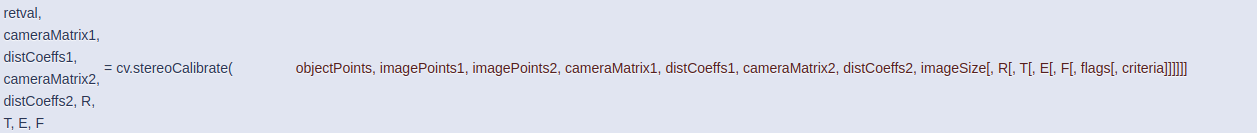

In [124]:
objectPoints.shape
imagePoints1.shape

(2, 15, 1, 2)